## DS 2500 Project
### Can you predict a song’s popularity based on its measured characteristics?

By Chase Yang, Suyasha, Shreya Mookherjee, Yasmine Bader


Importing necessary data:

We sourced this audio song feature data from a database called ["Hugging Face"](https://huggingface.co/datasets/maharshipandya/spotify-tracks-dataset)



In [24]:
# Data loading + import modules
# HuggingFace dataset with 114k rows
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from datasets import load_dataset
from scipy.stats import zscore
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib
ds = load_dataset("maharshipandya/spotify-tracks-dataset")

In [25]:
# Return the first 5 rows of raw, unmanipulated data
df_uncleaned = pd.DataFrame(ds['train'])
df_uncleaned.head()


,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


We identified null values in the dataset. The only null values in the data are in the "artists", "album_name", and "track_name" columns, with 1 null value in each. We decided not to remove these rows because our model will be based off of quantitative data, and these three rows are qualitative. Therefore, the null values will not affect the model and may be useful later in analysis.

In [26]:
# Identify and remove null values and unnecessary columns
null_values = df_uncleaned.isnull().sum()
print(f'Null values in the dataset:\n{null_values}')

Null values in the dataset:
Unnamed: 0          0
track_id            0
artists             1
album_name          1
track_name          1
popularity          0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
track_genre         0
dtype: int64


We want to check whether songs are duplicated or not. "track_id" is used to check for duplicated songs. Distinct songs will have a different track id, but duplicated songs will have the same track id. 24,529 songs are duplicated and must be removed. The resulting datatset has ~89,000 songs and removed 11 outliers.

In [27]:
def clean_data(df_uncleaned):
  """
  Parameters: df: a DataFrame containing all of the raw song data
  Does: - Removes duplicate songs based on track_id
        - Removes outliers using Z-score for "popularity"
        - Removes songs if the Z-score is > 3 or < -3
  Returns: df: DataFrame that contains data with no duplicates and no popularity
    outliers
  """
  num_duplicated = df_uncleaned[df_uncleaned['track_id'].duplicated()].shape[0]
  df = df_uncleaned.drop_duplicates(subset=['track_id']).copy()
  print(f'Number duplicated songs: {num_duplicated}\n'
    f'Number of rows in original dataframe: {df_uncleaned.shape[0]}\n'
    f'Number rows in cleaned dataframe: {df.shape[0]}')

  df['z-score'] = zscore(df['popularity'])
  outliers_idx = df.loc[(df['z-score'] > 3) | (df['z-score'] < -3)].index.tolist()
  print(f'Outliers dropped: {len(outliers_idx)}')
  df = df.drop(outliers_idx)

  return df



In [28]:
df = clean_data(df_uncleaned)

Number duplicated songs: 24259
Number of rows in original dataframe: 114000
Number rows in cleaned dataframe: 89741
Outliers dropped: 11


The cleaned dataset contains 89,741 datapoints. The target variable
(popularity) has a mean value of 33.19, and a standard deviation of 20.56. The high standard deviation indicates highly variable data. See below.

In [29]:
df['popularity'].describe()

,popularity
count,89730.000000
mean,33.190616
std,20.569951
min,0.000000
25%,19.000000
50%,33.000000
75%,49.000000
max,94.000000


We wanted to observe the number of genres in the dataset, and the number of songs associated with each genre. Before cleaning, each of the 114 genres had exactly 1,000 songs. After cleaning, the genres have a different amount of songs. In the next 2 cells, you can see how the number of songs per genre was 1,000 but some drop to less than 500 songs per genre after cleaning.

In [30]:
# Shows the song count in each genere before cleaning the data and removing outliers and duplicated songs
num_genres = len(df['track_genre'].unique())
num_songs_per_genre = df.value_counts('track_genre')
print(f'Number of genres: {num_genres}\n\nSongs in each genre: {num_songs_per_genre}')

Number of genres: 113

Songs in each genre: track_genre
acoustic     1000
afrobeat      999
alt-rock      999
ambient       999
cantopop      999
             ... 
metal         232
punk          226
house         210
indie         134
reggaeton      74
Name: count, Length: 113, dtype: int64


In [31]:
# Shows the song count in each genere after cleaning the data and removing outliers and duplicated songs
num_genres = len(df['track_genre'].unique())
num_songs_per_genre = df.value_counts('track_genre')
print(f'Number of genres: {num_genres}\n\nSongs in each genre: {num_songs_per_genre}')

Number of genres: 113

Songs in each genre: track_genre
acoustic     1000
afrobeat      999
alt-rock      999
ambient       999
cantopop      999
             ... 
metal         232
punk          226
house         210
indie         134
reggaeton      74
Name: count, Length: 113, dtype: int64


As you can see, there is an uneven amount of songs per genre. In order to perform a high quality linear regression, we must further clean the data to remove genres containing only a few songs, since a small sample size will not result in accurate predictions.

We decided to check the song counts for Acoustic, K-pop, and Mandopoo since those are the genres we personally listen to and interest us the most. Since they all have about an equal amount of songs, we decided to move forward with just these 3 genres.




In [32]:
chosen_genres = ['acoustic', 'k-pop', 'mandopop']

for genre in chosen_genres:
  count = (df['track_genre'] == genre).sum()
  print(f"{genre}:{count}")



acoustic:1000
k-pop:917
mandopop:873


Before creating our models, we needed to normalize the data and change any categorical variables to 1 or 0 through hot one encoding. In the code below, we converted Explicit to a 0 or 1 since originally it was a boolean and a regression cannot read this. We also converted Duration from milliseconds to minutes.

In [33]:
def normalize_convert_data(df):
  """
  Parameters: df: a DataFrame containing all of the cleaned song data
  Does: - Conducts one-hot encoding for the "explicit" column
        - Converts the "duration" column from seconds to minutes
        - Converts all numeric columns on a scale of 0-1 using MMS
  Returns: df: DataFrame that contains the newly converted data
  """
  df = df.copy()
  df['duration_min'] = (df['duration_ms']/60000).round(2)
  df['explicit'] = df['explicit'].map({False: 0, True: 1})
  scaler = MinMaxScaler()
  mms_cols = ['popularity', 'danceability', 'energy', 'loudness', 'speechiness',
              'acousticness', 'instrumentalness', 'liveness', 'valence',
              'tempo']
  df[mms_cols] = scaler.fit_transform(df[mms_cols])
  return df

df = normalize_convert_data(df)
df.head()



,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,z-score,duration_min
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,0.776596,230666,0,0.686294,0.4610,...,0.148187,0.032329,0.000001,0.3580,0.718593,0.361245,4,acoustic,1.933926,3.84
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,0.585106,149610,0,0.426396,0.1660,...,0.079067,0.927711,0.000006,0.1010,0.268342,0.318397,4,acoustic,1.059320,2.49
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,0.606383,210826,0,0.444670,0.3590,...,0.057720,0.210843,0.000000,0.1170,0.120603,0.313643,4,acoustic,1.156499,3.51
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,0.755319,201933,0,0.270051,0.0596,...,0.037617,0.908635,0.000071,0.1320,0.143719,0.746758,3,acoustic,1.836747,3.37
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,0.872340,198853,0,0.627411,0.4430,...,0.054508,0.470884,0.000000,0.0829,0.167839,0.492863,4,acoustic,2.371228,3.31


For the three genres we are comparing in our example analysis, we wanted to make sure they were diverse enough from each other to be compared in terms of four metrics - popularity, energy, instrumentalness, and acousticness. We also compared them to the mean metrics of all the genres to see how our 3 chosen genres compare to the other data as a whole.

In [34]:
'''
sources:
- .capitalize()
 - https://www.w3schools.com/python/ref_string_capitalize.asp

- .mean()
 - https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.mean.html

- Using ax for 2x2 subplot grid and .set_title()
 - https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html
 - .set_ylabel()
   - https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.set_ylabel.html

'''

def create_bar_plot(genres_lst, metric, dframe, ax):
  '''
  Parameters: - genres_lst: a list of genres shown in the bar plot
              - metric: numeric columns used to calculate means
              - dframe: DataFrame that has all cleaned song data
              - ax: the matplotlib arguemnt used to plot
  Does: - Calculates the mean of each metric
        - For the genre called "All" it computes the overall average
        - Capitalize the genre names for the barplot display
        - Creates a bar plot showing the average metrics for all the genres
  Returns: None
  '''
  metric_means = []
  genres_capitalized = [genre.capitalize() for genre in genres_lst]

  for genre in genres_lst:
    if genre == "all":
      metric_means.append(dframe[metric].mean())
    else:
     metric_means.append(dframe.loc[dframe["track_genre"] ==
       genre, metric].mean())

  ax.bar(genres_capitalized, metric_means)
  ax.set_title(f"Average {metric.capitalize()} by Genre")
  ax.set_xlabel("Genre")
  ax.set_ylabel(f"Average {metric.capitalize()}")

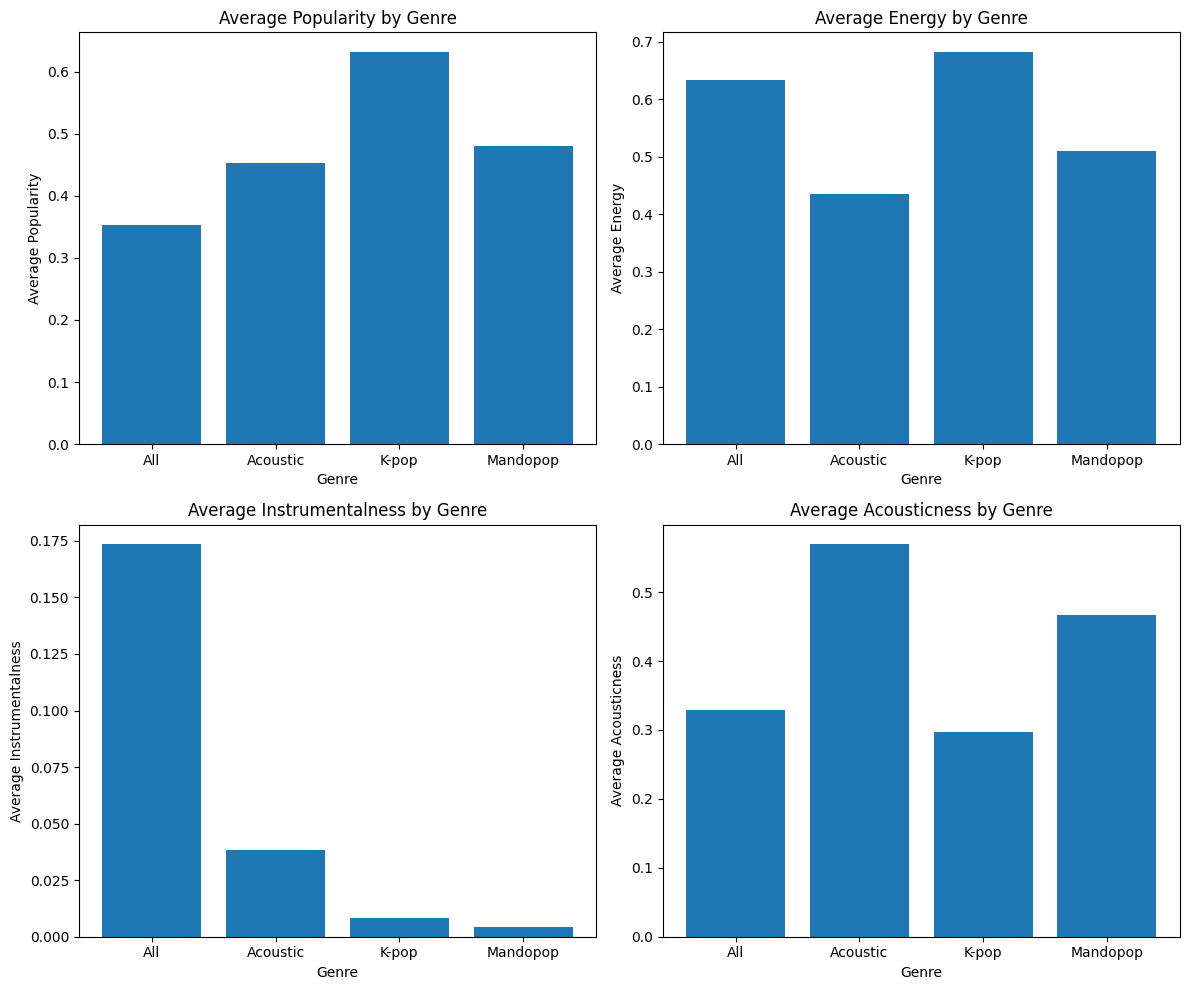

In [35]:
'''
sources:
- axes (just plural of ax)
 - https://matplotlib.org/stable/api/axes_api.html

- Ensure looping over every subplot as opposed to every row in subplot grid by
 - making it 1D instead of 2D
 - https://numpy.org/doc/2.1/reference/generated/numpy.ndarray.flatten.html

- Ensures proper spacing between subplots
 - https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.tight_layout.html

'''
# Create bar plots to show average popularity in chosen genres + all genres
genres_focus = ["all", "acoustic", "k-pop", "mandopop"]
metrics = ["popularity", "energy", "instrumentalness", "acousticness"]

fig, axes = plt.subplots(2, 2, figsize=(12,10))

axes = axes.flatten()

for ax, metric in zip(axes, metrics):
 create_bar_plot(genres_focus, metric, df, ax)

plt.tight_layout()
plt.show()

We are interested in finding the features that contribute the most to song popularity among different genres. These features will change depending on the genre. For example, "danceability" will likely be an important contributing factor to popularity for k-pop songs (given that this genre has a lot of choreography), but the same feature may not affect the popularity of an acoustic song, for which "acousticness" may be more important.

The following function takes song genre as an arguement, and finds the correlation each feature has to song popularity. The function then returns the features that have a higher correlation to popularity, returning the top 5 most important features.

In [36]:
# create correlation map function
features = ["duration_ms", "explicit","danceability", "energy", "key",
  "loudness", "mode", "speechiness", "acousticness", "instrumentalness",
  "liveness", "valence", "tempo", "time_signature", 'popularity']
target = 'popularity'

def get_imp_features(genre):
  """
  Parameters: genre: Genre name we are analyzing
  Does: - Filters the dataset to only include songs from the selected genre
        - Uses a correlation matrix to discover how each feature affects popularity
  Returns: top5_features: a string containing the top 5 song features that affect popularity
  """
  genre_df = df[df['track_genre'] == genre]
  corr = genre_df[features].corr()[target]
  feat_corr = list(zip(features, corr))
  feat_corr = list(filter(lambda x: x[0] != 'popularity', feat_corr))

  feat_corr = [(i, abs(j)) for (i, j) in feat_corr]
  top5_feat_and_corr = sorted(feat_corr, key=lambda t: t[1], reverse=True)[:5]
  top5_features = [i for (i, j) in top5_feat_and_corr]
  return top5_features

print(f"Important features for k-pop: {get_imp_features('k-pop')}")
print(f"Important features for acoustic: {get_imp_features('acoustic')}")
print(f"Important features for mandopop: {get_imp_features('mandopop')}")

Important features for k-pop: ['loudness', 'acousticness', 'energy', 'duration_ms', 'time_signature']
Important features for acoustic: ['energy', 'valence', 'explicit', 'loudness', 'acousticness']
Important features for mandopop: ['time_signature', 'duration_ms', 'loudness', 'valence', 'tempo']


We also wanted to create heatmaps to show the correlation of all numeric features with a chosen genre to help visualize the most and least important features. This will allow artists and song producers to see which audio features their song should emphasize if they want a hit song.

In [37]:
def heatmap(data, row_labels, col_labels, ax=None, cbar_kw=None,
   cbarlabel="", **kwargs):
   """
   Create a heatmap from a numpy array or DataFrame and two lists of labels.

    Args:
    data
        A 2D numpy array or 2d Dataframe of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted. If
        not provided, use current Axes or create a new one. Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`. Optional.
    cbarlabel
        The label for the colorbar. Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.

   Returns: im, cbar: A heatmap and colorbar for the data passed in.
   """

   if ax is None:
       ax = plt.gca()

   if cbar_kw is None:
       cbar_kw = {}

   # plot the heatmap
   im = ax.imshow(data, **kwargs)

   # create colorbar
   cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
   cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

   # show all ticks and label them with the respective list entries
   ax.set_xticks(range(data.shape[1]), labels=col_labels,
                 rotation=-30, ha="right", rotation_mode="anchor")
   ax.set_yticks(range(data.shape[0]), labels=row_labels)

   # let the horizontal axes labeling appear on top
   ax.tick_params(top=True, bottom=False,
                  labeltop=True, labelbottom=False)

   # turn spines off and create white grid
   ax.spines[:].set_visible(False)

   ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
   ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
   ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
   ax.tick_params(which="minor", bottom=False, left=False)

   return im, cbar

def annotate_heatmap(im, data=None, valfmt="{x:.2f}", textcolors=("black",
   "white"), threshold=None, **textkw):
   """
   A function to annotate a heatmap.

   Args:
   im
       The AxesImage to be labeled.
   data
       Data used to annotate.  If None, the image's data is used. Optional.
   valfmt
       The format of the annotations inside the heatmap. This should either
       use the string format method, e.g. "$ {x:.2f}", or be a
       `matplotlib.ticker.Formatter`. Optional.
   textcolors
       A pair of colors.  The first is used for values below a threshold,
       the second for those above. Optional.
   threshold
       Value in data units according to which the colors from textcolors are
       applied.  If None (the default) uses the middle of the colormap as
       separation. Optional.
   **kwargs
       All other arguments are forwarded to each call to `text` used to create
       the text labels.


   Returns: texts: the annotations for the heatmap
   """

   if not isinstance(data, (list, np.ndarray)):
       data = im.get_array()

   # normalize the threshold to the images color range
   if threshold is not None:
       threshold = im.norm(threshold)
   else:
       threshold = im.norm(data.max())/2.

   # set default alignment to center, but allow it to be overwritten by textkw
   kw = dict(horizontalalignment="center",
             verticalalignment="center")
   kw.update(textkw)

   # get the formatter in case a string is supplied
   if isinstance(valfmt, str):
       valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

   # loop over the data and create a `Text` for each "pixel". change the
       # text's color depending on the data
   texts = []
   for i in range(data.shape[0]):
       for j in range(data.shape[1]):
           kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
           text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
           texts.append(text)

   return texts

def plot_heatmap(df, features, genre):
   """
   Parameters:
       - DataFrame: df
       - list: features (list of song features)
   Does: plots the correlation annotated heatmap following the two helper
       functions for the annotated heatmap, and shows it
   Returns: none
   """

   corr_nums = df[features].corr()

   # cmap options:
       # https://matplotlib.org/stable/users/explain/colors/colormaps.html
   im, cbar = heatmap(corr_nums, row_labels = features, col_labels = features,
      ax = ax, cmap = "cool", cbarlabel = "Correlation")

   # due to **textkw parameter in annotate_heatmap(), can set fontsize so don't
    # have large numbers (font-size wise) that overlap with each other
    # see documentation above for this
   annotate_heatmap(im, fontsize = 5)

   # capitalizing:
    # https://www.w3schools.com/python/ref_string_capitalize.asp
   ax.set_title(f"Correlation Heatmap - Song Features for {genre.capitalize()}")

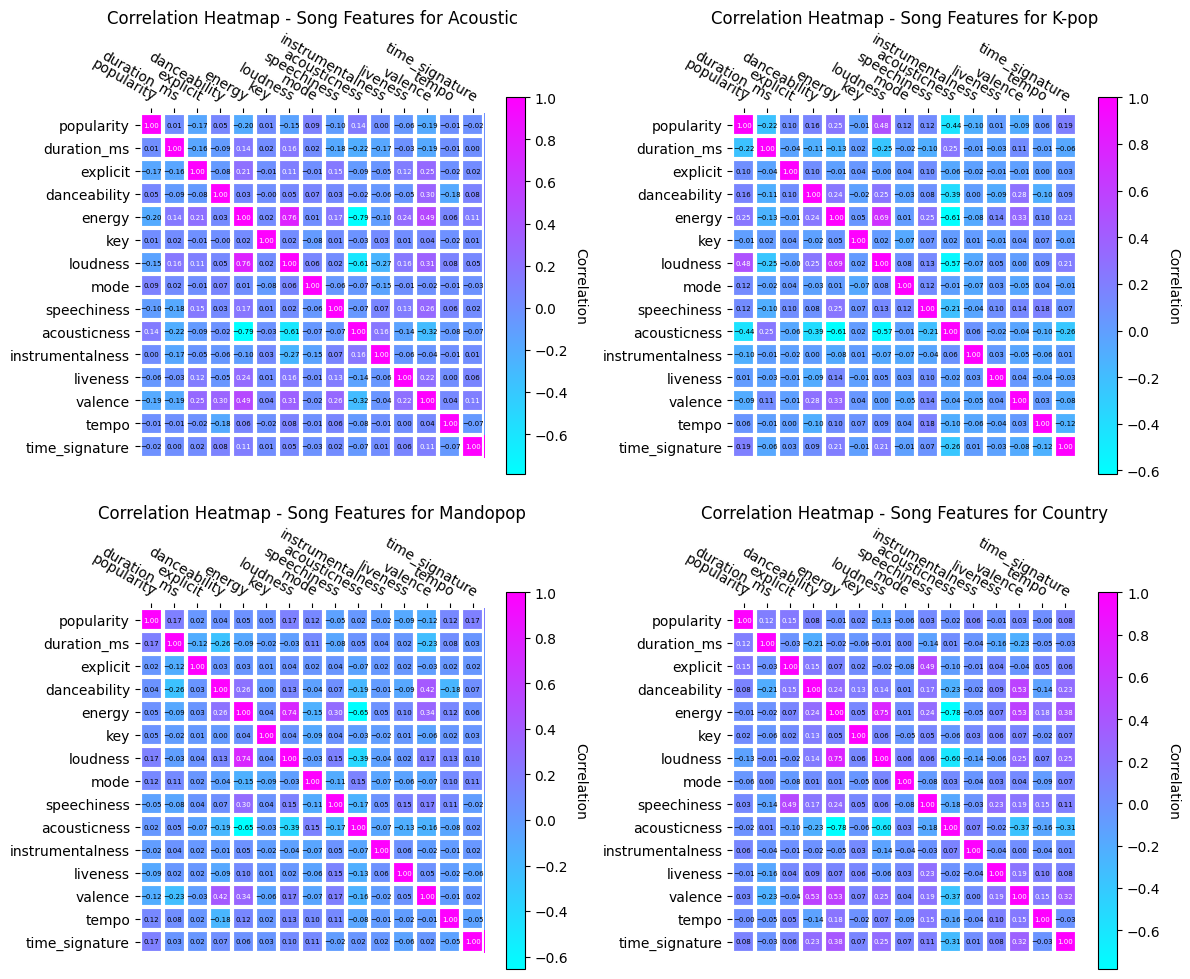

In [38]:
genres_focus_two = ["acoustic", "k-pop", "mandopop", "country"]
all_features = ["popularity", "duration_ms", "explicit", "danceability",
  "energy", "key", "loudness", "mode", "speechiness", "acousticness",
  "instrumentalness", "liveness", "valence", "tempo", "time_signature"]

# using subplots like what did above for bar charts
fig, axes = plt.subplots(2, 2, figsize=(12,10))

axes = axes.flatten()

# subsetting: https://pandas.pydata.org/docs/getting_started/intro_tutorials/03_subset_data.html
for ax, genre in zip(axes, genres_focus_two):
  plot_heatmap(df[df["track_genre"] == genre], all_features, genre)

plt.tight_layout()
plt.show()

In the following function, a linear regression model is used to predict song popularity based on previously determined important song characteristics.

In [39]:
def linear_regression(genre):
  """
  Parameters: The specific genre the Linear regression will run on
  Does: - Selects only the rows in the dataset that matches that genre name
        - Gets the features for that genre from get_imp_features()
        - Splits the data into training and testing sets (80/20)
        - Fits a linear regression on training data
  Returns:  - y_pred: the predicted popualarity values
            - y_test: the actual popularity for the test set
            - X_test: x inputs used for prediction
            - m: slope of the regression line
            - b: the y-intercept of the regression line
  """
  imp_feat = get_imp_features(genre)
  # changed from df to df_cleaned
  X_train, X_test, y_train, y_test = train_test_split(df[imp_feat],
    df['popularity'], test_size=0.2, random_state=42)
  model = LinearRegression()
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  m = model.coef_[0]
  b = model.intercept_

  return y_pred, y_test, X_test, m, b


To determine the effectiveness of the linear regression model, Mean Squared Error and R-squared values are determined. This function returns these values for a given genre.

In [40]:
def mse_r2(genre):
  '''
  Parameters: genre: the specific genre chosen for the linear regression earlier
  Does: - Runs the linear_regression() fucntion to get the actual and predicted values
        - Calculates the Mean Squared Error
        - Calculates the R Squared value
  Returns:  - mse: float, the Mean Squared Error for the selected genre
            - r2: float, the R squared for the selected genre
  '''
  y_pred, y_test = linear_regression(genre)[:2]
  mse = mean_squared_error(y_test,y_pred)
  r2 = r2_score(y_test,y_pred)
  return mse, r2


The previously tested genres are tested below. Each genre returns a very low r-squared value, close to zero, showing that the linear regression model did not do a good job predicting song popularity among these three genres and cannot make precise predictions. Therefore, linear regression is not the correct model for our data.

In [41]:
kpop_mse, kpop_r2 = mse_r2('k-pop')
print(f"Kpop MSE: {round(kpop_mse, 4)}")
print(f"Kpop r2: {round(kpop_r2, 4)}")

acoustic_mse, acoustic_r2 = mse_r2('acoustic')
print(f"\nAcoustic MSE: {round(acoustic_mse, 4)}")
print(f"Acoustic r2: {round(acoustic_r2, 4)}")

mandopop_mse, mandopop_r2 = mse_r2('mandopop')
print(f"\nMandopop MSE: {round(mandopop_mse, 4)}")
print(f"Mandopop r2: {round(mandopop_r2, 4)}")

Kpop MSE: 0.0469
Kpop r2: 0.0096

Acoustic MSE: 0.0468
Acoustic r2: 0.0118

Mandopop MSE: 0.047
Mandopop r2: 0.0075


We know that the test cases performed poorly using linear regression. However, we don't know if these cases are outliers, so MSE and R^2 values are calculated for each genre. We will then perform an analysis to see the overall performance of the linear regression model.  

In [42]:
all_genres = list(df['track_genre'].unique())
all_mse = []
all_r2 = []
for i in all_genres:
  all_mse.append(mse_r2(i)[0])
  all_r2.append(mse_r2(i)[1])

The following descriptive statistics show that the mean R^2 value amongst all genres is 0.014, and that the values range from 0.00158 to 0.0292. This shows that there are no genres for which linear regression is an accurate predictive model.  

In [43]:
print(f'Descriptive stats on all R^2 values:\n {pd.DataFrame(all_r2).describe()}\n\n')
print(f'Descriptive stats on all MSE values:\n {pd.DataFrame(all_mse).describe()}')

Descriptive stats on all R^2 values:
                 0
count  113.000000
mean     0.012679
std      0.005798
min      0.001325
25%      0.008042
50%      0.011579
75%      0.017344
max      0.028668


Descriptive stats on all MSE values:
                 0
count  113.000000
mean     0.046793
std      0.000275
min      0.046035
25%      0.046572
50%      0.046845
75%      0.047013
max      0.047331


We want to also look at features against popularity across different genres. So we ran a Linear Regression between features like "explicit" and "duartion_ms" versus "popularity" in 3 different genres.

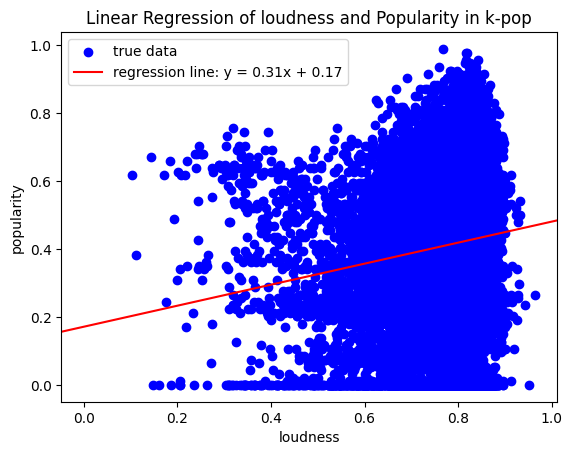

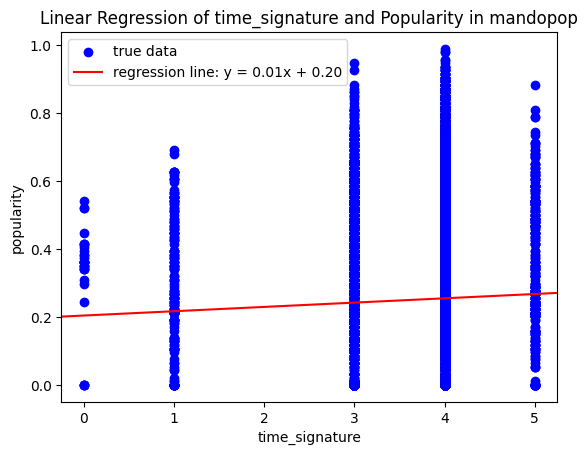

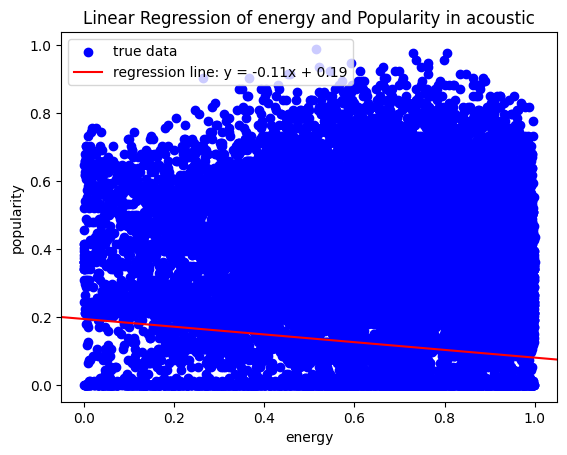

In [44]:
def plot_most_imp_feat(genre):
  '''
  Arguments: genre: the genre chosen for the Linear Regression
  Does: - Finds the most important feature for that genre using get_imp_feature()
        - Runs the Linear Regression for that genre
        - Creates a scatter plot bewteen features and popularity for each genre
  Returns: None
  '''

  most_imp_feat = get_imp_features(genre)[0]
  y_pred, y_test, X_test, m, b = linear_regression(genre)
  plt.scatter(X_test[most_imp_feat], y_test, color='blue', label='true data')
  plt.axline(xy1 = (0, b), slope = m, color = 'red', label=f'regression line: y = {m:.2f}x + {b:.2f}')
  plt.xlabel(f'{most_imp_feat}')
  plt.ylabel('popularity')
  plt.title(f'Linear Regression of {most_imp_feat} and Popularity in {genre}')
  plt.legend()
  plt.show()

plot_most_imp_feat('k-pop')
plot_most_imp_feat('mandopop')
plot_most_imp_feat('acoustic')



After realizing the linear regression model is not the right fit for the data, according to MSE and R-Squared values, we decided to use a KNN classifier model to see if it would be better at predicting popularity. We then evaluated the model and found the best k value (number of neighbors) for each genre in the next 2 cells

In [45]:
from sklearn.metrics import confusion_matrix
def evaluate_knn(num_neighbors, genre):
  """
  Finds predicted values based on KNN model using train and test data
  Args: desired number of neighbors and genre to model
  Returns: predicted accuracy value of the created KNN model
  """
  genre_df = df[df['track_genre'] == genre].copy()
  genre_df['is_popular'] = (genre_df['popularity'] >= .5).astype(int)
  imp_feat = get_imp_features(genre)

  X_train, X_test, y_train, y_test = train_test_split(genre_df[imp_feat], genre_df['is_popular'], test_size=0.2, random_state=42)
  knn = KNeighborsClassifier(n_neighbors = num_neighbors)
  knn.fit(X_train,y_train)
  y_pred = knn.predict(X_test)
  cm = confusion_matrix(y_test, y_pred)
  acc = float((cm[0,0] + cm[1,1]) / cm.sum())
  return round(acc, 2)


In [46]:
def find_k_accs(list_nums, genre):
  k_vals_acc = []
  for k in list_nums:
    k_vals_acc.append((k, evaluate_knn(k, genre)))
  return k_vals_acc

list_nums = [1, 3, 5, 7, 9]
print(f"K values and their corresponding accuracies for K-pop:\n {find_k_accs(list_nums, 'k-pop')}\n")
print(f"K values and their corresponding accuracies for Mandopop:\n {find_k_accs(list_nums, 'mandopop')}\n")
print(f"K values and their corresponding accuracies for Acoustic:\n {find_k_accs(list_nums, 'acoustic')}")


K values and their corresponding accuracies for K-pop:
 [(1, 0.69), (3, 0.78), (5, 0.76), (7, 0.79), (9, 0.8)]

K values and their corresponding accuracies for Mandopop:
 [(1, 0.55), (3, 0.58), (5, 0.57), (7, 0.59), (9, 0.58)]

K values and their corresponding accuracies for Acoustic:
 [(1, 0.59), (3, 0.6), (5, 0.65), (7, 0.65), (9, 0.65)]


In the end, although our linear model explained almost none of the variance in popularity, the KNN model classified songs with up to ~80% accuracy, showing it is far better suited for this prediction task.

Moving forward, based on our “get_imp_features” function, artists and producers now know that “loudness” should be emphazised in a K-pop song, “energy” for an Acoustic song, and “time signature” for a Mandopop song